In [1]:
import tensorflow as tf

from smot.jupyter import model_reports
from smot.problems.mnist import mnist_lib

In [2]:
# Load (and cache) standard MNIST dataset.
(x_train, y_train), (x_test, y_test) = mnist_lib.load_mnist_data_28x28x1()

In [3]:
model = mnist_lib.build_ijcal2011_mnist_model()

# Print the model summary.
model.summary()

batch_size = 128
validation_split = 0.2
epochs = 50

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    shear_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    validation_split=validation_split,
)
datagen.fit(x_train)

training_generator = datagen.flow(
    x_train,
    y_train,
    subset="training",
    batch_size=batch_size,
)
validation_generator = datagen.flow(
    x_train,
    y_train,
    subset="validation",
    batch_size=batch_size,
)

Model: "LeNet5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 20)        520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 40)        20040     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 40)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 60)          60060     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 60)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 80)          12008

Epoch 1/50
375/375 [==============================] - 6s 9ms/step - loss: 0.7275 - accuracy: 0.7646 - val_loss: 0.1178 - val_accuracy: 0.9628
Epoch 2/50
375/375 [==============================] - 4s 8ms/step - loss: 0.1163 - accuracy: 0.9623 - val_loss: 0.0996 - val_accuracy: 0.9690
Epoch 3/50
375/375 [==============================] - 4s 8ms/step - loss: 0.0844 - accuracy: 0.9739 - val_loss: 0.0723 - val_accuracy: 0.9775
Epoch 4/50
375/375 [==============================] - 4s 8ms/step - loss: 0.0736 - accuracy: 0.9764 - val_loss: 0.0774 - val_accuracy: 0.9765
Epoch 5/50
375/375 [==============================] - 4s 8ms/step - loss: 0.0614 - accuracy: 0.9801 - val_loss: 0.0624 - val_accuracy: 0.9807
Epoch 6/50
375/375 [==============================] - 4s 8ms/step - loss: 0.0549 - accuracy: 0.9836 - val_loss: 0.0576 - val_accuracy: 0.9819
Epoch 7/50
375/375 [==============================] - 4s 8ms/step - loss: 0.0498 - accuracy: 0.9837 - val_loss: 0.0497 - val_accuracy: 0.9853
Epoch 

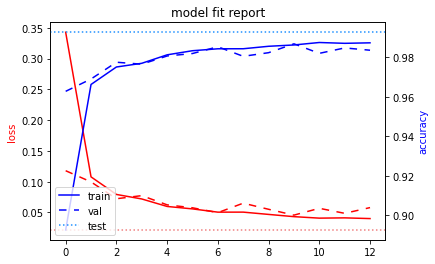

In [4]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3),
]

history = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=epochs,
    verbose=1,
    use_multiprocessing=True,
    workers=12,
    callbacks=callbacks,
)

# Evaluate the model with the test data.
test_loss, test_accuracy = model_reports.model_fit_report(
    model=model,
    history=history,
    test_data=(x_test, y_test),
)